In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from collections import OrderedDict
from manifold_helper import ManifoldHelper


rng = np.random.default_rng(seed=42)

def plot_images(data, n_img_per_row=10, cmap='gray'):
    shape = int(np.sqrt(len(data[0])))
    # plot iage of the digits
    img = np.zeros( (shape * n_img_per_row, shape * n_img_per_row) )
    for i in range( n_img_per_row ):
        ix = shape * i
        for j in range( n_img_per_row ):
            iy = shape * j
            img[ix:ix + shape, iy:iy + shape] = data[i * n_img_per_row + j].reshape( (shape, shape) )

    plt.figure(figsize=(15, 15))
    plt.imshow( img, cmap=cmap )
    plt.xticks( [] )
    plt.yticks( [] )
    plt.show()

In [2]:
n_class = 10 # n primeiros digitos
class_percent = 0.05 # porcentagem dos dados de cada classa que serão usados
rescale_factor = 1.0
is_invert = False
neighbors = [5, 10, 25, 50, 75, 100, 150, 200]
dimensions = [2, 5, 10, 50, 100, 150, 200]
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']

# Carregando os dados

In [3]:
datasetOriginal = pd.read_csv("data\\mnist_train.csv")
df = datasetOriginal.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separar os rotulos dos dados
label, x = df.iloc[:, :1], df.iloc[:, 1:]
label = label.to_numpy().transpose()[0]
x = x.to_numpy()
label, x

(array([5, 0, 4, ..., 5, 6, 8], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [5]:
# sort de acordo com os labels
idx = np.argsort(label)
label = label[idx]
x = x[idx]
label, x

(array([0, 0, 0, ..., 9, 9, 9], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [6]:
unique, counts = np.unique(label, return_counts=True)
num_data = dict(zip(unique, counts))
num_data

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

## Selecionando dados para analise

In [7]:
# selecionando apenas parte dos dados
x_cut = np.empty((0, 784))
label_cut = np.empty((1, 0), dtype=np.uint8)
for i in range(n_class):
    if i > 0:
        start = sum([num_data[j] for j in range(i)])
        end = int(num_data[i] * class_percent) + start
    else:
        start = 0
        end = int(num_data[i] * class_percent)
    label_cut = np.append(label_cut, label[start : end])
    x_cut = np.vstack((x_cut, x[start : end, :]))

unique, counts = np.unique(label_cut, return_counts=True)
num_data_cut = dict(zip(unique, counts))
num_data_cut

{0: 296,
 1: 337,
 2: 297,
 3: 306,
 4: 292,
 5: 271,
 6: 295,
 7: 313,
 8: 292,
 9: 297}

In [8]:
idx = np.random.RandomState(seed=42).permutation(len(x_cut))
x_cut = x_cut[idx, :]
label_cut = label_cut[idx]

In [9]:
label_colors = [list( mcolors.TABLEAU_COLORS )[i] for i in range( 10 )]
colors = [label_colors[v] for v in label_cut]

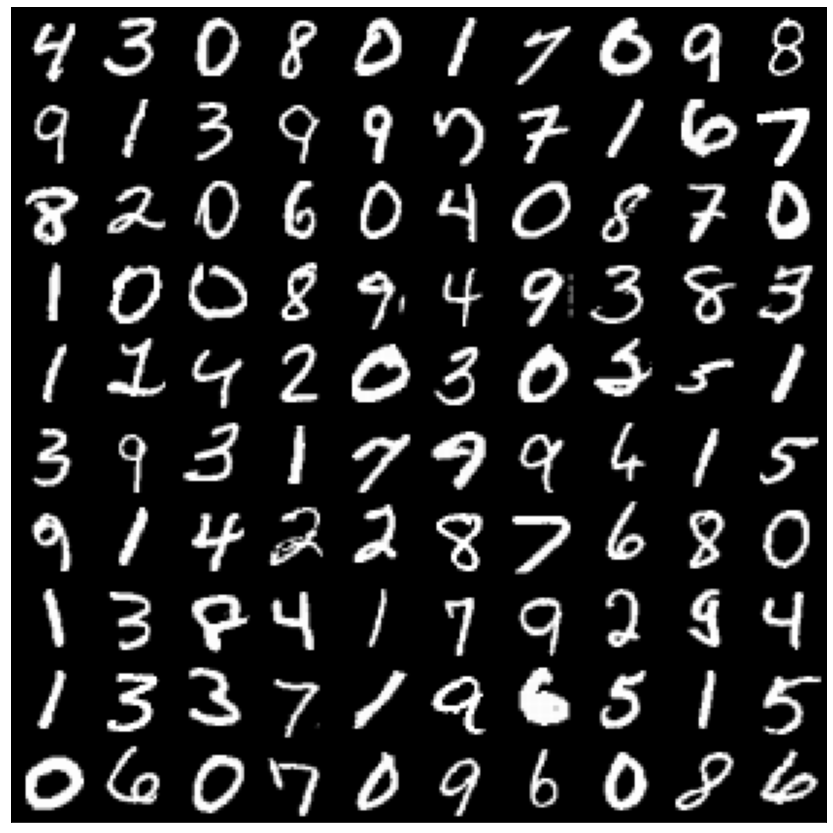

In [10]:
plot_images(x_cut)

# preprocessing

# ARI

In [11]:
data = x_cut

Gerando os métodos para cada valor de vizinhos no intervalo

In [15]:
manifold.evaluate_gmm_ari(data, label_cut, n_components=n_class)

0.32498579788693194

In [22]:
manifold.plot_ari_results(ari_results, methods)

NameError: name 'plt' is not defined

In [23]:
manifold.saveARI(ari_results, add='id_8')

NameError: name 'os' is not defined

In [24]:
def saveARI(ari_results, path='results/', add=''):
        for method, data in ari_results.items():
            if not os.path.isfile(f'{path}{method}_{add}.npy'):
                with open(f'{path}{method}_{add}.npy', 'wb') as file:
                    np.save(file, data)
                    print(data)
            else:
                print(f'File exists! saveARI does not override.')

In [25]:
saveARI(ari_results, add='id_8')

[[0.27720729 0.26396472 0.2621638  0.24517468 0.22869922 0.26044533
  0.2353823  0.21514132]
 [0.52285255 0.51621439 0.36062442 0.36198037 0.36574116 0.33953687
  0.3907193  0.43423754]
 [0.59126975 0.61526767 0.47982279 0.499847   0.41035367 0.45706991
  0.42660381 0.47981916]
 [0.54315944 0.59388408 0.48469087 0.47515504 0.45783098 0.48872881
  0.53770605 0.53186693]
 [0.52292173 0.46057247 0.37875795 0.40411367 0.39153793 0.43189688
  0.38211949 0.39394367]
 [0.50924269 0.46674364 0.41531476 0.35920317 0.39909719 0.32052619
  0.32317047 0.35319703]
 [0.43270569 0.44464954 0.38249787 0.30988463 0.35428999 0.34079777
  0.37698069 0.32599228]]
[[0.43920726 0.38009022 0.06475419 0.05523623 0.05932517 0.09361926
  0.05504939 0.04460824]
 [0.49557044 0.35520181 0.22955856 0.20101758 0.14939191 0.14981616
  0.16929148 0.19569376]
 [0.5663795  0.40543395 0.30135439 0.23590152 0.21641735 0.20842581
  0.25973506 0.31145313]
 [0.57145596 0.53186557 0.41166403 0.47868373 0.39022815 0.43419615
 

In [2]:
import numpy as np
from megaman.geometry import Geometry
from megaman.embedding import Isomap

X = np.random.randn(100, 10)
radius = 5
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius} # ignore distances above this radius

geom  = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds)

isomap = Isomap(n_components=n_components, eigen_solver='arpack', geom=geom)
embed_isomap = isomap.fit_transform(X)

C:\Users\marco\anaconda3\envs\manifolds\lib\site-packages\megaman\geometry\rmetric.py:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode_inv is 'svd':
C:\Users\marco\anaconda3\envs\manifolds\lib\site-packages\megaman\geometry\rmetric.py:280: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode_inv is 'svd' and return_svd:


ModuleNotFoundError: No module named 'megaman.geometry.cyflann.index'